In [68]:
# import sys
# !{sys.executable} -m pip install pmdarima

In [69]:
# pip list

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## 데이터 불러오기

In [71]:
# AirPassengers data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ap = pd.read_csv(url)
ap.drop('Month', axis = 1, inplace = True)
print(ap.head())

   Passengers
0         112
1         118
2         132
3         129
4         121


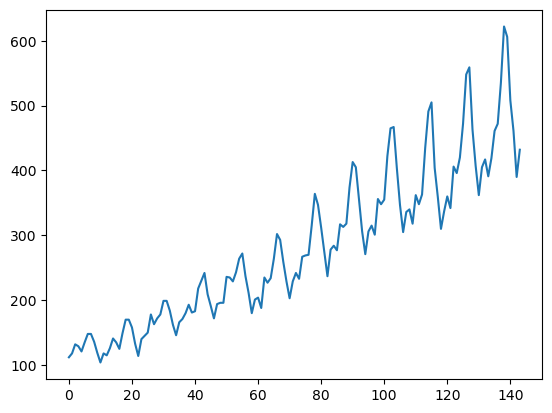

In [72]:
plt.plot(ap)
plt.show()

## 데이터 전처리

### 로그 변환을 통해 분산을 일정하게 조절

In [129]:
ap_tf = np.log(ap)

In [130]:
ap_tf

,Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


acf와 pacf로 그래프를 그리면,  
몇 시점 전까지의 값이 현재 값에 영향을 주는지 시각적으로 파악할 수 있다.

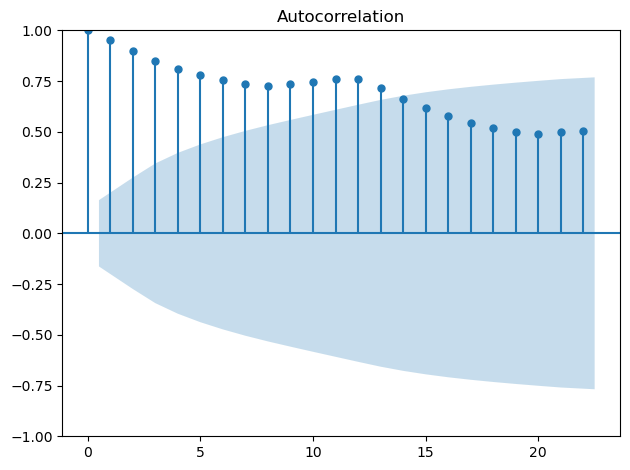

In [131]:
plot_acf(ap_tf) # acf_plot 
plt.tight_layout()

ACF/PACF 그래프에서 지속적인 높은 자기상관이 보이면 비정상성 시계열일 가능성이 높다.

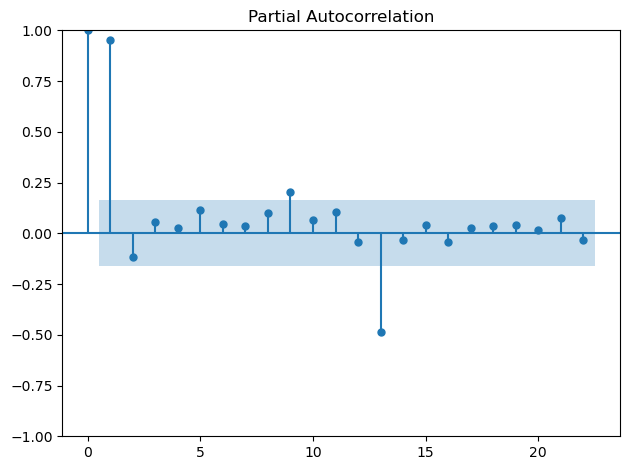

In [132]:
plot_pacf(ap_tf)
plt.tight_layout()

acf_plot: 점점 감소하는 경향  
pacf_plot: lag 2까지 유의미한 결과를 보임

### 차분을 통해 추세 제거

In [133]:
ap_diff = ap_tf.diff()
ap_diff = ap_diff.dropna()

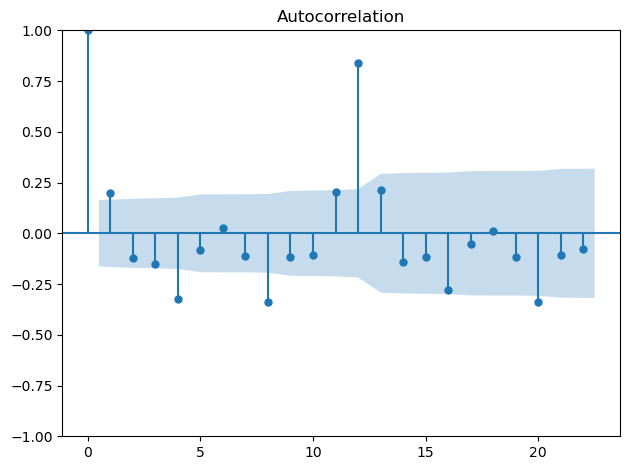

In [134]:
plot_acf(ap_diff)
plt.tight_layout()

lag 1 과 lag 12 에서 유의미한 lag 가 포착됨

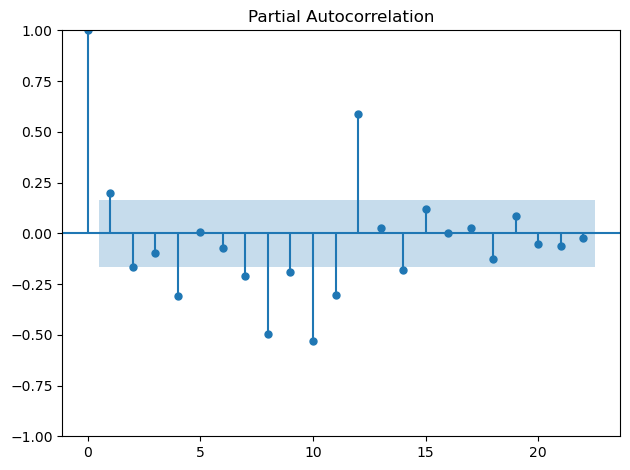

In [135]:
plot_pacf(ap_diff)
plt.tight_layout()

lag 1 과 lag 8~12 에서 유의미한 lag 가 포착됨

acf와 pacf에서 n=12쯤 유의미한 상관관계가 나타남.  
이는 계절성 성분으로 생각하고,  
auto-arima를 적합할 때 계절성을 고려하도록 해야 함.

### 계절 차분

In [113]:
ap_diff = ap_tf.diff(12)
ap_diff = ap_diff.dropna()

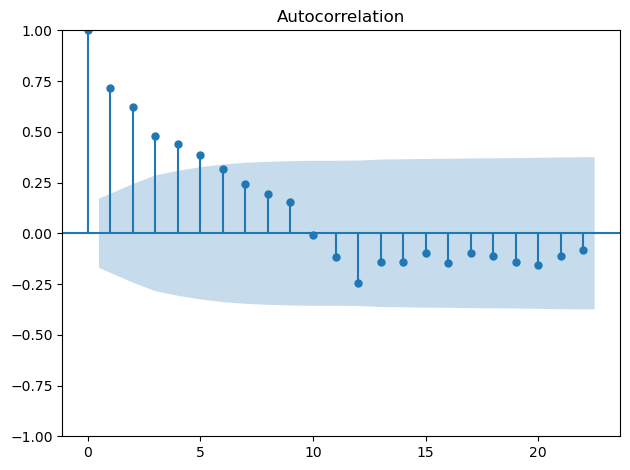

In [114]:
plot_acf(ap_diff)
plt.tight_layout()

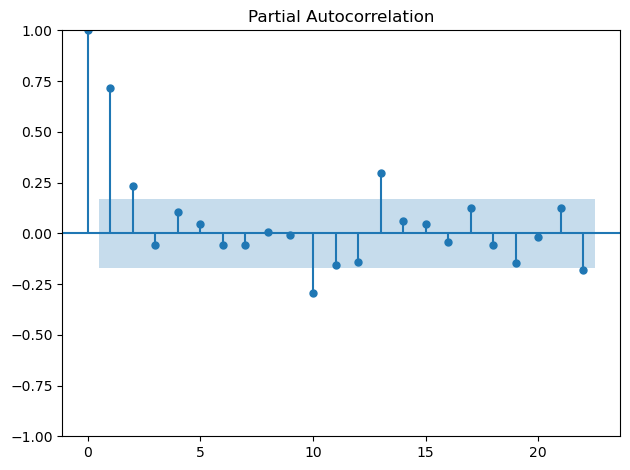

In [115]:
plot_pacf(ap_diff)
plt.tight_layout()

n=2,3,10,13 쯤 유의미한 상관관계가 나타남.  
ACF 2,3 -> 짧은 기간 내 패턴이나 효과가 지속됨  
PACF 10, 13 -> 긴 시차 효과가 있을 때  
계절성 제거 후에도 lag 2,3에서 단기적 자기상관, lag 10,13에서 장기적 자기상관이 있다.  
데이터에 2~3개월 이내 단기 패턴과 함께 약 1년 주기의 장기 반복 패턴이 함께 존재한다고 판단하였다.

### ARIMA를 적합할 때 계절성 요인도 고려

In [117]:
ap_tf

,Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


### 데이터셋 분리 (train, test)

In [118]:
train_size = int(len(ap_tf)*0.8)
train_size

115

In [119]:
ap_tf_train = ap_tf[:train_size]
ap_tf_test = ap_tf[train_size:]

### auto-arima 로 모델 적합

In [121]:
ap_tf.isna().mean()

Passengers    0.0
dtype: float64

계절 차분은 일정한 주기를 기준으로 데이터를 차분해 계절성을 제거하는 것  
`.diff(12)`연산 또는 `auto_arima`의 `seasonal=True, D=1` 설정을 통해 동일한 효과를 얻을 수 있다.  
  
Q1. `auto_arima`에서 차분으로 생긴 결측치 제거는 어떻게 해주나요?  
→ 차분 후 생긴 null값은 모델 적합 시 자동 제외. 단, 데이터 자체에 NA는 처리 후 적합.  
air passengers.csv 파일에서 null값은 존재하지 않음.

In [120]:
# seasonal=True로 체크
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_d = 12, D=12)
# 차분 후 생긴 NA는 모델 적합 시 자동 제외. 단, 데이터 자체에 NA는 처리 후 적합
res = model.fit(ap_tf_train)
res

C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-213.739, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.01 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.581, Time=0.29 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-215.679, Time=0.31 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-218.853, Time=0.36 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=0.29 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-219.386, Time=0.43 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.633, Time=0.47 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-214.662, Time=0.51 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-223.361, Time=0.36 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-217.007, Time=0.50 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-197.568, Time=0.27 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-215.500, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-199.544, Time=0.19 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.037 seconds


AutoARIMA(D=12, max_d=12, trace=True)

Best model:  ARIMA(5,1,2)(0,0,0)[0]

In [127]:
model = pm.AutoARIMA(seasonal=False, suppress_warnings = True, trace = True) # 계절 차분 False
res = model.fit(ap_tf_train)
res

C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-213.739, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.01 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.581, Time=0.36 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-215.679, Time=0.36 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-218.853, Time=0.48 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=0.22 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-219.386, Time=0.44 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.633, Time=0.42 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-214.662, Time=0.43 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-223.361, Time=0.34 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-217.007, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-197.568, Time=0.19 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-215.500, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-199.544, Time=0.20 sec


C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 5.544 seconds


AutoARIMA(seasonal=False, trace=True)

Best model:  ARIMA(5,1,2)(0,0,0)[0]

### ARIMA(5,1,2) 모델이 가장 적합하다고 나옴

### 계절성 있음에도 Best model: ARIMA(5,1,2)(0,0,0)[0] 선정 이유 분석
1. 계절성을 자동 탐색했지만 계절 차분(D)까지 하지 않아도 안정적이라 판단.  
-> 정말 그러한지, AutoARIMA에서 계절성 요인을 고려하지 않고 AutoARIMA를 진행하였으나,  
같은 결과가 나왔으므로 계절 차분까지 하지 않아도 된다고 판단 -> ok

2. 비계절 AR, MA 항으로 충분히 설명 가능하다고 본 것.  
-> AR(5) → 5개월간의 자기상관 존재, MA(2) → 2개월간의 오차항 영향  
   실제로 airline-passenger 데이터는 연간 계절성(m=12)이 있지만, 단기 자기상관이 더 큰 설명력을 가지기도 함.

In [105]:
preds, conf_int = res.predict(n_periods=ap_tf_test.shape[0], return_conf_int=True)
# confidence interval까지 도출

C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\juwonhee\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [106]:
print(preds.shape)
print(type(preds))
print('--'*15)
print(preds.shape[0])
print(type(preds.shape[0]))
print('--'*15)
print(preds)
print('--'*15)
print(conf_int)

(29,)
<class 'pandas.core.series.Series'>
------------------------------
29
<class 'int'>
------------------------------
115    6.176214
116    6.182071
117    6.099738
118    6.030763
119    6.097969
120    6.113729
121    6.094691
122    6.148871
123    6.123316
124    6.072517
125    6.120769
126    6.111686
127    6.078911
128    6.132751
129    6.120188
130    6.079614
131    6.126978
132    6.115426
133    6.078761
134    6.127931
135    6.117933
136    6.080627
137    6.126992
138    6.116946
139    6.080379
140    6.126230
141    6.117400
142    6.081388
143    6.125788
dtype: float64
------------------------------
[[6.01243868 6.33998944]
 [5.90255119 6.46159106]
 [5.73063885 6.4688366 ]
 [5.61449045 6.44703646]
 [5.66114948 6.53478839]
 [5.66022354 6.56723491]
 [5.61889959 6.57048264]
 [5.64765755 6.650085  ]
 [5.5919308  6.65470169]
 [5.51166679 6.63336702]
 [5.53812709 6.70341138]
 [5.50890599 6.71446692]
 [5.45561332 6.702209  ]
 [5.49118889 6.77431213]
 [5.45860288 6.7817

In [107]:
print(ap_tf_train.shape[0])
print(preds.shape[0])

115
29


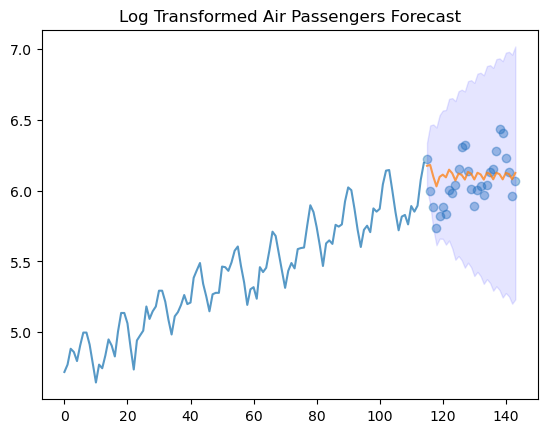

In [128]:
x_axis = np.arange(ap_tf_train.shape[0] + preds.shape[0])
plt.plot(x_axis[:ap_tf_train.shape[0]],ap_tf_train, alpha=0.75)
plt.plot(x_axis[ap_tf_train.shape[0]:], preds, alpha=0.75)
plt.scatter(x_axis[ap_tf_train.shape[0]:],ap_tf_test,
            alpha=0.4, marker='o')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Log Transformed Air Passengers Forecast") 
plt.show() 

즉, 계절성은 부가적인 요소일 뿐, 이 데이터에서는 단기 자기상관이 핵심 구조라는 결론 도출.

## ARCH

### 🔍 왜 ARCH 모델을 쓰게 되었을까?  
ARIMA는 평균(추세 + 자기상관) 중심의 모델이다.  
→ 데이터의 **변동성(분산)** 이 시간에 따라 변화하는 경우는 잘 설명하지 못한다.  

만약 잔차를 분석했는데,  

1. 분산이 일정하지 않고
2. 큰 변동과 작은 변동이 반복된다면
→ 조건부 이분산성(Volatility Clustering) 현상이다.  

이럴 땐 ARCH / GARCH 모델을 추가로 적용해서 예측값의 불확실성(variance)까지 모델링한다.

In [87]:
import sys
!{sys.executable} -m pip install arch

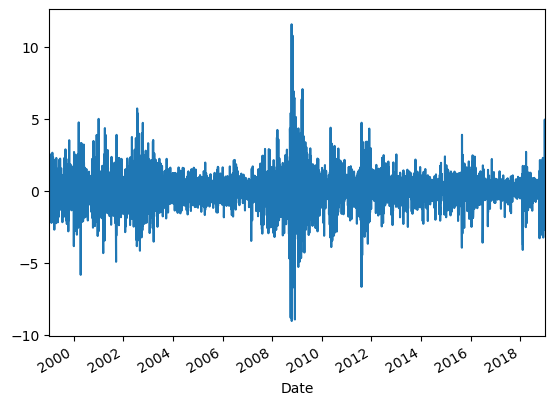

In [88]:
import datetime as dt
import arch.data.sp500

st = dt.datetime(2002,1,1) # start date
en = dt.datetime(2022,1,1) # end date
data = arch.data.sp500.load() 
market = data["Adj Close"] # 종가만 활용
returns = 100 * market.pct_change().dropna() # return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
plt.show()

Conditional Heteroskedasticity(=조건부 이분산성)가 나타남
#### 조건부 이분산성
- 평균은 일정한데, 분산이 시간에 따라 변하는 현상
- 그래프에서 변동 폭이 시간에 따라 커졌다 작아졌다 하는 모습이 보임
- 잔차의 제곱값 혹은 절대값이 자기상관성을 가지면 조건부 이분산성 가능성 높음
- 보통 ARCH 효과 검사에 사용

=> Volatility Clustering 변동성 클러스터링의 전형적인 신호이며, ARCH/GARCH 모델을 적용할 수 있다는 근거다.

### ARCH 적합

In [111]:
from arch import arch_model # 기본 모델이 garch model을 적합하도록 설계

# ARCH만 원할 경우 vol='ARCH'로 명시해줘야 함.
am = arch_model(returns) # return을 garch모델에 적합
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Mon, May 26 2025   Df Residuals:                     5029
Time:         

volatility model을 보면,  
alpha[1], Beta[1] 은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 99%에서 이들이 유의미함을 도출

## 시각화

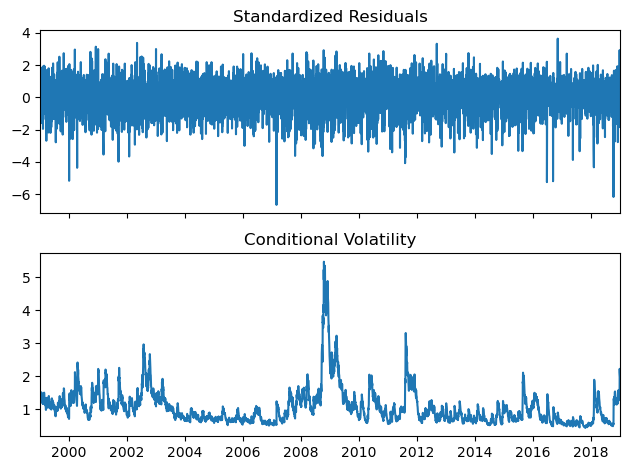

In [90]:
res.plot()
plt.tight_layout()

모델 적합 후 남은 잔차(Residual)와 포착한 조건부 변동성(conditional volatility)을 시각적으로 확인

1. 모델 적합: ARCH/GARCH 모델이 금융 시계열 데이터의 변동성 포착
   
2. 표준화 잔차 확인: 상단 그래프의 표준화 잔차 평균이 0에 가깝고, 분산이 일정하므로 변동성을 잘 설명하고 있다.
   
3. 조건부 변동성 및 클러스터링 현상: 하단 그래프의 조건부 변동성은 시간에 따른 변동성의 변화를 명확히 보여준다.  
- 2008-2009년 변동성 급증: 이 시기에 변동성이 가장 크게 치솟았는데, 이는 당시 발생했던 **글로벌 금융 위기(서브프라임 모기지 사태)** 와 직접적으로 연관된다. 이 위기는 미국 부동산 시장 붕괴에서 시작되어 전 세계 금융 시장에 큰 충격을 주었던 시기이다.  